# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# read csv to get sign names
sign_names = []
with open('signnames.csv') as signname_file:
    signname_reader = csv.DictReader(signname_file)
    sign_names = [row['SignName'] for row in signname_reader]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import numpy

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = numpy.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

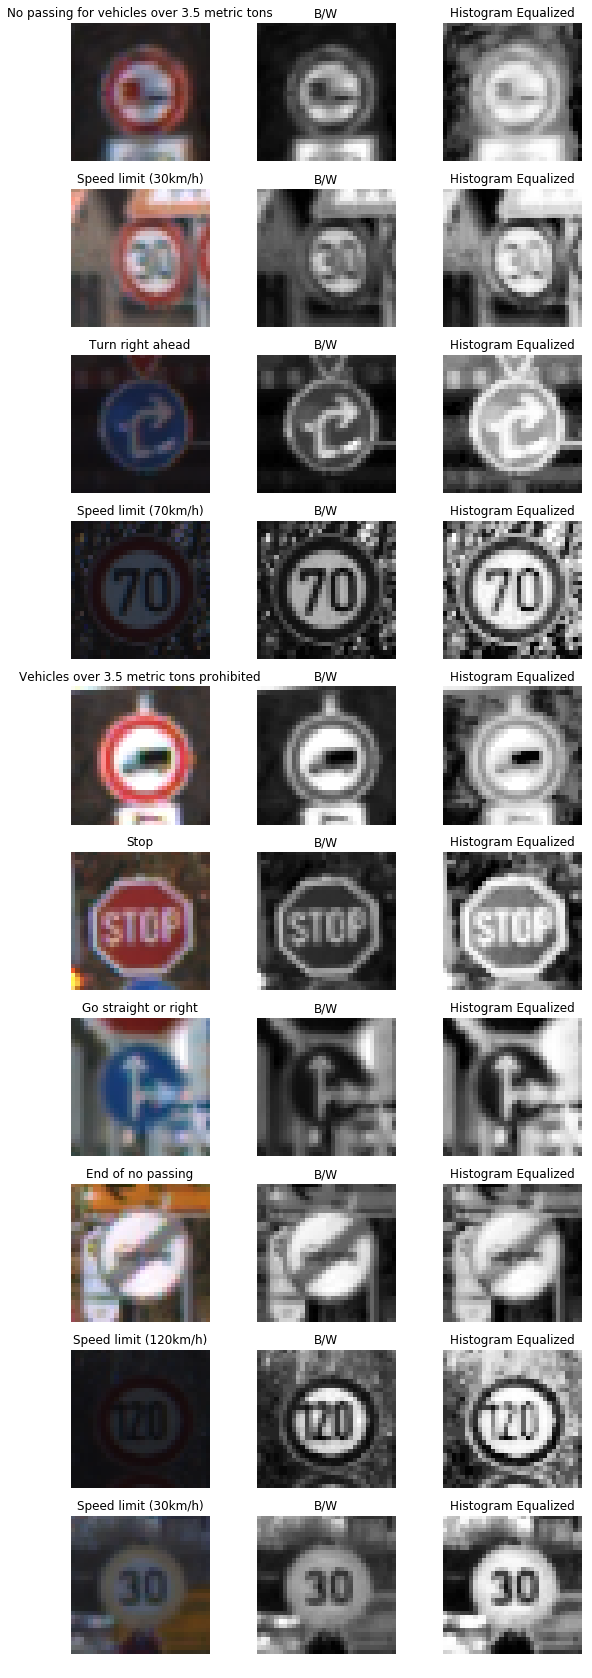

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import cv2
import numpy

# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of N random data points
count = 10
fig, axs = plt.subplots(count, 3, figsize=(count, count*3))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(0, count*3, 3):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(sign_names[y_train[index]])

    bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    axs[i+1].axis('off')
    axs[i+1].imshow(bw, cmap='gray')
    axs[i+1].set_title("B/W")

    equ = cv2.equalizeHist(bw)
    axs[i+2].axis('off')
    axs[i+2].imshow(equ, cmap='gray')
    axs[i+2].set_title("Histogram Equalized")

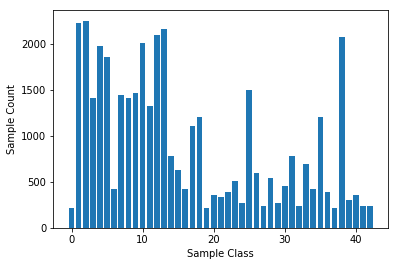

In [4]:
import numpy as np

# plotting the count of each sign

y_pos = range(n_classes)
label_list = y_train.tolist()
sign_type = [label_list.count(y) for y in range(n_classes)]

plt.bar(y_pos, sign_type, width=0.8, align='center')
plt.ylabel('Sample Count')
plt.xlabel('Sample Class')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
import cv2
import numpy as np
from numpy import newaxis

# convert to B/W
X_train_bw = numpy.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_train])
X_test_bw = numpy.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_test])

# apply histogram equalization
X_train_hst_eq = numpy.array([cv2.equalizeHist(image) for image in X_train_bw])
X_test_hst_eq = numpy.array([cv2.equalizeHist(image) for image in X_test_bw])

# reshape for conv layer
X_train_reshaped = X_train_hst_eq[..., newaxis]
X_test_reshaped = X_test_hst_eq[..., newaxis]
print('Before shaping:', X_train_hst_eq.shape)
print('After shaping:', X_train_reshaped.shape)

# normalize range
X_train_normalized = X_train_reshaped - np.mean(X_train_reshaped)
X_test_normalized = X_test_reshaped - np.mean(X_test_reshaped)
print('Mean, min and max before normalizing:', np.mean(X_train_reshaped), np.min(X_train_reshaped), np.max(X_train_reshaped))
print('Mean, min and max after normalizing:', np.mean(X_train_normalized), np.min(X_train_normalized), np.max(X_train_normalized))

Before shaping: (39209, 32, 32)
After shaping: (39209, 32, 32, 1)
Mean, min and max before normalizing: 131.701958599 0 255
Mean, min and max after normalizing: 1.33848118614e-14 -131.701958599 123.298041401


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1. The input images were converted to black and white. This helps in multiple ways - it reduces the amount of data to process, it allows the network to learn faster, because there is less complexity as well as it is easier to equalize the histogram in the next step.  
2. The brightness values are equalized using the histogram equalisation method. I am not using CLAHE because the images are very small and seemed like overkill here.
3. Then, the most important step is to normalize the values to go from -1 to +1 instead of going from 0 to 255. This helps keep the weights smaller and lets the network fit the curve faster.

In [6]:
import scipy.ndimage

def create_variant(image):
    if (random.choice([True, False])):
        image = scipy.ndimage.interpolation.shift(image, [random.randrange(-2, 2), random.randrange(-2, 2), 0])
    else:
        image = scipy.ndimage.interpolation.rotate(image, random.randrange(-10, 10), reshape=False)
    return image

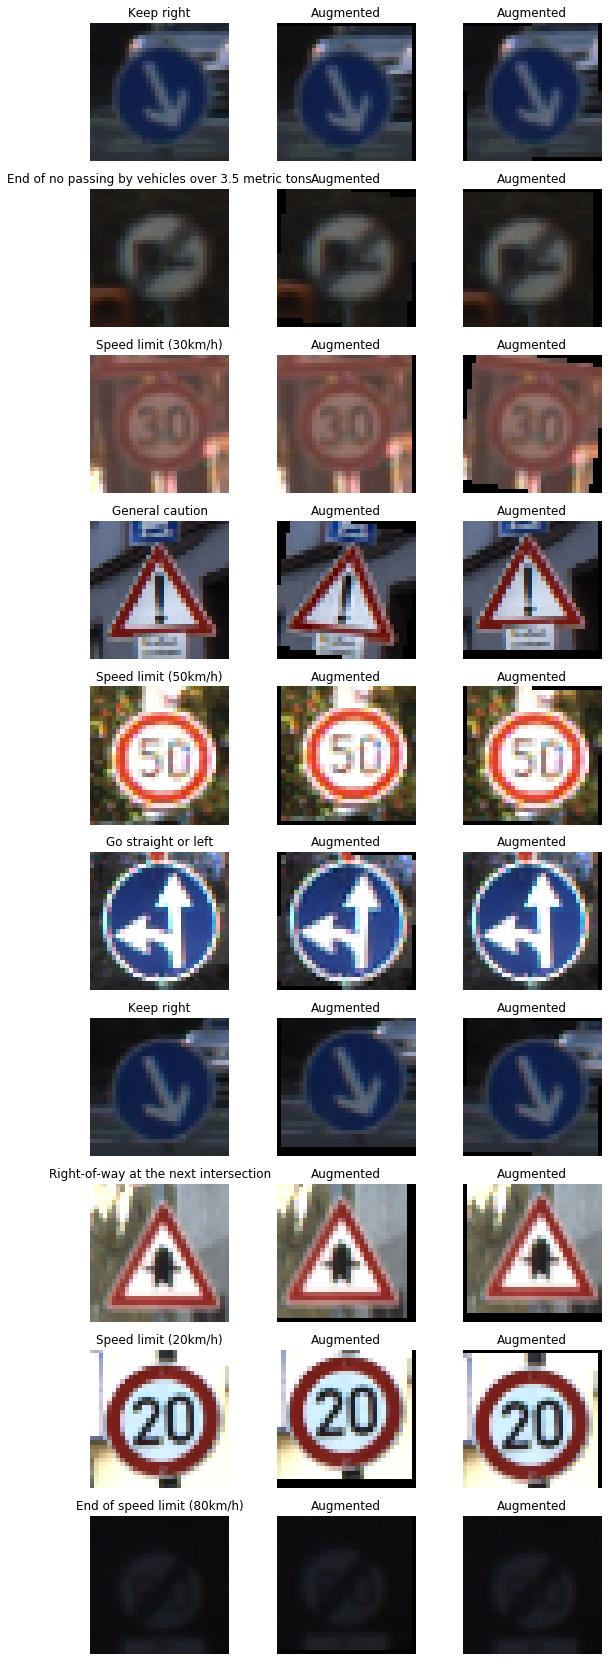

In [7]:
# show image of N random data points
count = 10
fig, axs = plt.subplots(count, 3, figsize=(count, count*3))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(0, count*3, 3):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(sign_names[y_train[index]])

    aug1 = create_variant(image)
    axs[i+1].axis('off')
    axs[i+1].imshow(aug1)
    axs[i+1].set_title("Augmented")
    
    aug2 = create_variant(image)
    axs[i+2].axis('off')
    axs[i+2].imshow(aug2)
    axs[i+2].set_title("Augmented")

In [8]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
    
# data augmentation
REQ_NUM_SAMPLES = 1000

generated_features = []
generated_labels = []

for class_index in range(len(sign_type)):
    class_sample_count = sign_type[class_index]
    augment_multiple = round(REQ_NUM_SAMPLES / class_sample_count)

    if augment_multiple <= 1:
        continue
    
    print("Class {:d} has only {:d} samples, hence augmenting {:d} times.".format(class_index, class_sample_count, augment_multiple))
    for test_feature, test_label in zip(X_train_normalized, y_train):
        if class_index == test_label:
            for augment_iter in range(augment_multiple):
                generated_features.append(create_variant(test_feature))
                generated_labels.append(test_label)

# append generated data to original data
X_train_augmented = np.append(np.array(X_train_normalized), np.array(generated_features), axis=0)
y_train_augmented = np.append(np.array(y_train), np.array(generated_labels), axis=0)

Class 0 has only 210 samples, hence augmenting 5 times.
Class 6 has only 420 samples, hence augmenting 2 times.
Class 15 has only 630 samples, hence augmenting 2 times.
Class 16 has only 420 samples, hence augmenting 2 times.
Class 19 has only 210 samples, hence augmenting 5 times.
Class 20 has only 360 samples, hence augmenting 3 times.
Class 21 has only 330 samples, hence augmenting 3 times.
Class 22 has only 390 samples, hence augmenting 3 times.
Class 23 has only 510 samples, hence augmenting 2 times.
Class 24 has only 270 samples, hence augmenting 4 times.
Class 26 has only 600 samples, hence augmenting 2 times.
Class 27 has only 240 samples, hence augmenting 4 times.
Class 28 has only 540 samples, hence augmenting 2 times.
Class 29 has only 270 samples, hence augmenting 4 times.
Class 30 has only 450 samples, hence augmenting 2 times.
Class 32 has only 240 samples, hence augmenting 4 times.
Class 34 has only 420 samples, hence augmenting 2 times.
Class 36 has only 390 samples, he

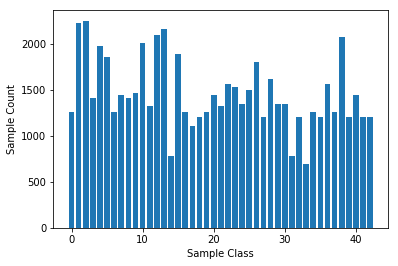

In [9]:
# plotting the count of each sign

y_pos = range(n_classes)
label_list = y_train_augmented.tolist()
sign_type = [label_list.count(y) for y in range(n_classes)]

plt.bar(y_pos, sign_type, width=0.8, align='center')
plt.ylabel('Sample Count')
plt.xlabel('Sample Class')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# create validation set from training data
X_training, X_validation, y_training, y_validation = train_test_split(X_train_augmented, y_train_augmented, test_size=0.2)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. I already had testing data. For validation data, I take a random slice of the training data.
2. Yes, I created additonal data.
3. To generate the data, I first found the ratio between expected number of samples and actual. Then I took created random rotated variations on the images to satisfy expected sample count.
4. I generated this new data so that each class is equally represented in the data.
5. The difference between original and create data is that they are either rotated or translated randomly.

I created test and validation sets from original test data.

In [11]:
### Define your architecture here.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

def MiniNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    size = 32
    
    # Convolution and Pooling Layer
    F_W_1 = tf.Variable(tf.truncated_normal([5, 5, 1, int(size/2)], mean = mu, stddev = sigma)) # (height, width, input_depth, output_depth)
    F_b_1 = tf.Variable(tf.zeros(int(size/2))) # (output_depth)
    layer_conv1 = tf.nn.bias_add(tf.nn.conv2d(x, F_W_1, strides=[1, 1, 1, 1], padding='VALID'), F_b_1)
    layer_activation1 = tf.nn.relu(layer_conv1)
    layer_pooling1 = tf.nn.max_pool(layer_activation1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolution and Pooling Layer
    F_W_2 = tf.Variable(tf.truncated_normal([5, 5, int(size/2), size], mean = mu, stddev = sigma)) # (height, width, input_depth, output_depth)
    F_b_2 = tf.Variable(tf.zeros(size)) # (output_depth)
    layer_conv2 = tf.nn.bias_add(tf.nn.conv2d(layer_pooling1, F_W_2, strides=[1, 1, 1, 1], padding='VALID'), F_b_2)
    layer_activation2 = tf.nn.relu(layer_conv2)
    layer_pooling2 = tf.nn.max_pool(layer_activation2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    layer_flatten = tf.contrib.layers.flatten(layer_pooling2)
    layer_dropout = tf.nn.dropout(layer_flatten, 0.8)
   
    # Fully Connected Layer
    layer_fc1 = tf.contrib.layers.fully_connected(layer_dropout, int(size*4), tf.nn.relu)

    # Fully Connected Layer
    layer_fc2 = tf.contrib.layers.fully_connected(layer_fc1, int(size*2), tf.nn.relu)

    # Fully Connected Layer
    layer_fc3 = tf.contrib.layers.fully_connected(layer_fc2, 43, tf.nn.relu)

    logits = layer_fc3
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I am using the LeNet architecture. I have two layers of convolution with max-pooling. After than we have 3 fully connected layers. I briefly tried pruning the network and was able to get same performance out of just one single convolution layer, if I kept the kernel size high. I learnt that by splitting it into two layers with smaller kernel sizes, we can reduce compute load.

Layer 1: Convolution with 5x5 kernel and stride of 1 and output depth of 16. Max-pooled with stride 2.  
Layer 2: Convolution with 5x5 kernel and stride of 1 and output depth of 32. Max-pooled with stride 2.  
[Flatten]    
[Dropout with keep probability of 0.8]  
Layer 3: Fully-connected layer with 128 nodes.  
Layer 4: Fully-connected layer with 64 nodes.   
Layer 5: Output layer of 43 nodes.

In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.
import time
from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int64, (None))

EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.0009

logits = MiniNet(x)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

inference_operation = tf.argmax(logits, 1)
correct_prediction = tf.equal(inference_operation, y)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    inference_data = np.array([])
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy, loss, inference = sess.run([accuracy_operation, loss_operation, inference_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
        inference_data = np.append(inference_data, inference)
    return total_accuracy / num_examples, total_loss / num_examples, inference_data

with tf.Session() as sess:
    print("Training with {} inputs...".format(len(X_training)))
    print()
    sess.run(tf.global_variables_initializer())

    for i in range(EPOCHS):
        start_time =  time.time()
        num_examples = len(X_training)
        X_training, y_training = shuffle(X_training, y_training)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_training[offset:end], y_training[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy, validation_loss, inference_data = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print("Time Taken = {:.2f} sec".format(time.time() - start_time))
        print()
            
    saver.save(sess, 'lenet')
    print("Model saved")

Training with 50183 inputs...

EPOCH 1 ...
Validation Accuracy = 0.555
Validation Loss = 1.518
Time Taken = 44.96 sec

EPOCH 2 ...
Validation Accuracy = 0.824
Validation Loss = 0.576
Time Taken = 47.68 sec

EPOCH 3 ...
Validation Accuracy = 0.878
Validation Loss = 0.387
Time Taken = 39.64 sec

EPOCH 4 ...
Validation Accuracy = 0.907
Validation Loss = 0.287
Time Taken = 36.54 sec

EPOCH 5 ...
Validation Accuracy = 0.933
Validation Loss = 0.217
Time Taken = 42.23 sec

EPOCH 6 ...
Validation Accuracy = 0.942
Validation Loss = 0.200
Time Taken = 39.53 sec

EPOCH 7 ...
Validation Accuracy = 0.959
Validation Loss = 0.141
Time Taken = 41.45 sec

EPOCH 8 ...
Validation Accuracy = 0.953
Validation Loss = 0.171
Time Taken = 35.54 sec

EPOCH 9 ...
Validation Accuracy = 0.957
Validation Loss = 0.152
Time Taken = 33.57 sec

EPOCH 10 ...
Validation Accuracy = 0.964
Validation Loss = 0.119
Time Taken = 35.70 sec

EPOCH 11 ...
Validation Accuracy = 0.967
Validation Loss = 0.121
Time Taken = 35.93 sec


Test Accuracy = 0.912
Test Loss = 0.527


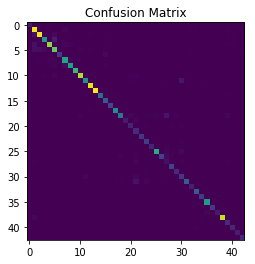

In [13]:
from sklearn.metrics import confusion_matrix

# Test model accuracy
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy, test_loss, inference_data = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Loss = {:.3f}".format(test_loss))
    
    plt.title('Confusion Matrix')
    plt.imshow(confusion_matrix(y_true = y_test,y_pred = inference_data))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


## **Answer:**

1. I am using the Adam Optimizer as part of the LeNet architecture.  
2. Batch size is 128.  
3. I am running this for 10 epochs.  
4. I am using hyperparameters of mean=0 and stddev=0.1  
5. Learning rate of 0.0009.  

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Yes, a lot of it was trial and error and building an intuition about how the parameters are related to each other. I had started with a more complex LeNet architecture and eventually reduced the network to a much simpler one. I realized that we really didn't need two convolution layers because the images are already cropped to the correct spot on the sign. Also we didn't need max-pooling because we were working with very small images and weren't doing a search on the image. But then I had very large kernel size, to reduce the kernel size, I had to go back to two levels of convolution and pooling pairs!

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Testing 15 test images...
Inferred classes: [14  7 17 17 12 40 13 22 13  1 21 12 13 17 17]


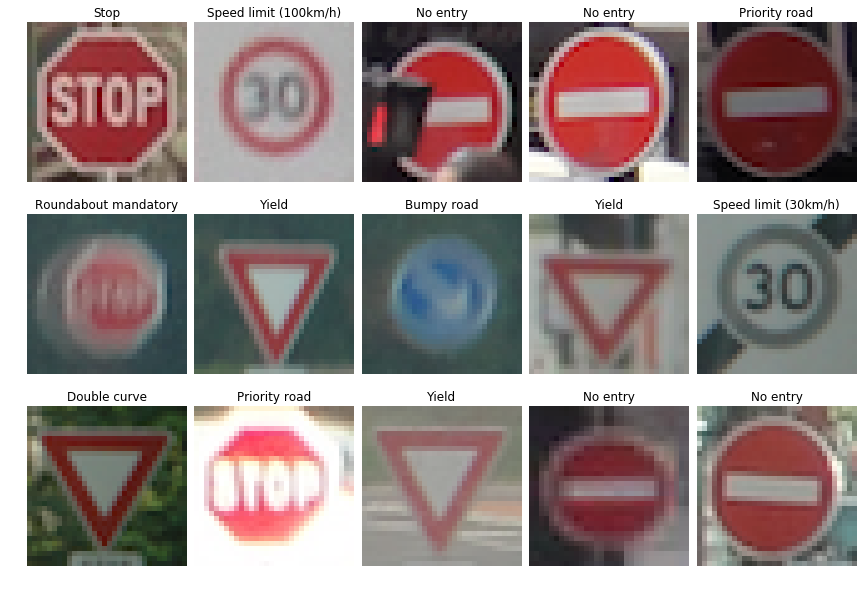

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg

# test on own images
own_images = np.array([mpimg.imread("own-data/" + imageName) for imageName in os.listdir("own-data")])

# for image in own_images:
#     plt.imshow(image)
#     plt.show()

# convert to B/W
own_images_bw = numpy.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in own_images])

# use absolute values
own_images_abs = numpy.array([cv2.convertScaleAbs(image) for image in own_images_bw])

# apply histogram equalization
own_images_hst_eq = numpy.array([cv2.equalizeHist(image) for image in own_images_abs])

# reshape for conv layer
own_images_reshaped = own_images_hst_eq[..., newaxis]

# normalize range
own_images_normalized = own_images_reshaped - np.mean(own_images_reshaped)

with tf.Session() as sess:
    print("Testing {} test images...".format(len(own_images)))
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    inference_output = sess.run(inference_operation, feed_dict={x: own_images_normalized})
    print("Inferred classes:", inference_output)

    count = len(own_images)
    fig, axs = plt.subplots(3, 5, figsize=(15, 10))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    for i in range(0, count):
        image = own_images[i]
        evaluated = inference_output[i]

        axs[i].axis('off')
        axs[i].set_title(sign_names[evaluated])
        axs[i].imshow(image)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**


I found around 15 image in my personal photo library where I had photos of the road. I cropped out the traffic signs visually - but they are slightly skewed during resize. Which means it would be nice to train the data after squeezing/stretching the input images a bit. Also, one of the images has an obstruction over part of the sign. Let's see if it still recognises it!

[14  5 37 17 29]


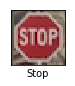

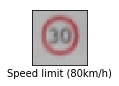

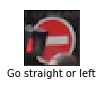

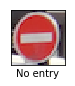

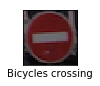

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

original_five = own_images[0:5]
sample_five = own_images_normalized[0:5]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    inference_output = sess.run(inference_operation, feed_dict={x: sample_five})
    print(inference_output)
    
for (image, evaluated)  in zip(original_five, inference_output):
    plt.figure(figsize=(1,1))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(sign_names[evaluated])
    plt.imshow(image)
    plt.show()



### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model performance is good for common signs like STOP and NO ENTRY. I took a slice of 5 images above. It guessed only 3 of them correct. That is an accuracy of 60% compared to above 90% on the test set. Hence the model has been overfitting and did not do equally well on real data. It is surprising that inspite of correctly recognising one of the No Entry signs correctly, it did not recognise the other two.

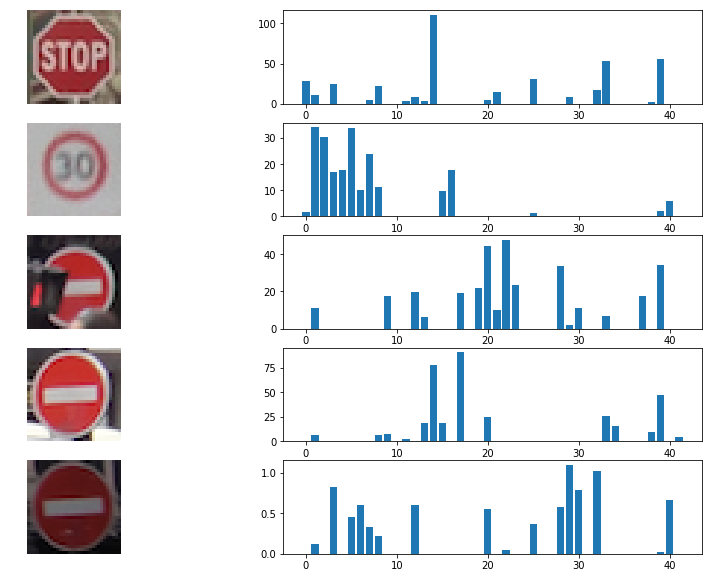

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

top_k_operation = tf.nn.top_k(logits, 42)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_output = sess.run(top_k_operation, feed_dict={x: sample_five})

    fig, axs = plt.subplots(5, 2, figsize=(15, 10))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    for i, top_k_indices, top_k_values, image in zip(range(0, 10, 2), top_k_output.indices, top_k_output.values, original_five):
        axs[i].axis('off')
        axs[i].imshow(image)

        axs[i+1].bar(top_k_indices, top_k_values)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

1. Got the first image right with decent confidence compared to other classes.  
2. In the second one, also it got it right. Though it seems to have predicted two classes with close confidence.  
3. In the third one, due the obstruction towards the left, it got it wrong. Though it is confident of its prediction.  
4. Got it correct, inspite of giving similar confidence to two other classes.  
5. Got it wrong, inspite of having recognised another similar one. Also it appears confused between multiple options.  

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.